In [1]:
# increase cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import gc
import time
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shapefile as shp
import geopandas as gpd

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [55]:
ca_df = gpd.read_file("../Data/Processed/CA_S2Cells/CA_S2Cells.shp")
ca_df = ca_df.to_crs({'init': 'epsg:4326'})
ca_df.rename(columns={'S2_Cells_I': 'S2_Cells_ID'}, inplace=True)
ca_df.shape

(10643, 9)

In [6]:
ca_wf = pd.read_csv('../Data/Processed/WildFire_S2Cells.csv')
ca_wf.shape

(3673, 46)

In [7]:
ca_wf.head()

,S2_Cells_ID,WF_ALARM_DATE_DT_DT,WF_WildFire_COUNT,WF_YEAR,WF_ALARM_DATE_MONTH,WF_WildFire,WF_GIS_ACRES,WF_Shape_Length,WF_Shape_Area,WF_FIRE_DUR,...,WF_C_METHOD_4,WF_C_METHOD_5,WF_C_METHOD_6,WF_C_METHOD_7,WF_C_METHOD_8,WF_WildFire_COUNT_1YR_AGO,WF_WildFire_COUNT_2YR_AGO,WF_WildFire_COUNT_3YR_AGO,WF_WildFire_COUNT_4YR_AGO,WF_WildFire_COUNT_5YR_AGO
0,54c942c,2017-07-24,1,2017,7,1,1492.397827,19322.129952,6.039520e+06,129.0,...,0,0,0,0,0,0,0,0,0,0
1,54c94c,2017-06-28,1,2017,6,1,653.507935,14766.199729,2.644653e+06,4.0,...,0,0,0,0,1,0,0,0,0,0
2,54c94d4,2017-06-28,1,2017,6,1,653.507935,14766.199729,2.644653e+06,4.0,...,0,0,0,0,1,0,0,0,0,0
3,54c94dc,2017-06-28,1,2017,6,1,653.507935,14766.199729,2.644653e+06,4.0,...,0,0,0,0,1,0,0,0,0,0
4,54c9524,2017-06-28,1,2017,6,1,653.507935,14766.199729,2.644653e+06,4.0,...,0,0,0,0,1,0,0,0,0,0


In [88]:
ca_wf.sort_values('WF_GIS_ACRES', ascending=False).head()

,S2_Cells_ID,WF_ALARM_DATE_DT_DT,WF_WildFire_COUNT,WF_YEAR,WF_ALARM_DATE_MONTH,WF_WildFire,WF_GIS_ACRES,WF_Shape_Length,WF_Shape_Area,WF_FIRE_DUR,...,WF_C_METHOD_4,WF_C_METHOD_5,WF_C_METHOD_6,WF_C_METHOD_7,WF_C_METHOD_8,WF_WildFire_COUNT_1YR_AGO,WF_WildFire_COUNT_2YR_AGO,WF_WildFire_COUNT_3YR_AGO,WF_WildFire_COUNT_4YR_AGO,WF_WildFire_COUNT_5YR_AGO
928,8083dec,2018-07-27,2,2018,7,1,459122.859375,444427.060729,1.858004e+09,70.0,...,0,0,0,2,0,0,0,0,2,0
929,8083df,2018-07-27,2,2018,7,1,459122.859375,444427.060729,1.858004e+09,70.0,...,0,0,0,2,0,0,0,0,2,0
863,8083c0c,2018-07-27,1,2018,7,1,410202.468750,348227.665079,1.660030e+09,55.0,...,0,0,0,1,0,0,0,0,0,0
871,8083c44,2018-07-27,1,2018,7,1,410202.468750,348227.665079,1.660030e+09,55.0,...,0,0,0,1,0,0,0,0,0,1
883,8083cb4,2018-07-27,1,2018,7,1,410202.468750,348227.665079,1.660030e+09,55.0,...,0,0,0,1,0,0,0,0,0,0


In [106]:
def bin_probs(probs):
    perc = {
        'low': 10,
        'low-med': 30,
        'med-high': 70,
        'high': 90} 
    perc_cuts = {}
    for p in perc:
        perc_cuts[p] = np.percentile(probs, perc[p])
    
    conditions = [
        (probs <= perc_cuts['low']),
        ((probs > perc_cuts['low']) & (probs <= perc_cuts['low-med'])),
        ((probs > perc_cuts['low-med']) & (probs <= perc_cuts['med-high'])),
        ((probs > perc_cuts['med-high']) & (probs <= perc_cuts['high'])),
        (probs > perc_cuts['high'])
    ]
    choices = ['1. low', '2. low-med', '3. med-high', '4. high', '5. extreme']
    
    return np.select(conditions, choices)

In [107]:
gc.collect()

0

In [108]:
mlp_adam_noprecip_cw2000_probs = pd.read_csv('./Models/mlp_adam_noprecip_cw2000_probs.csv')
mlp_adam_noprecip_cw2000_probs.reset_index(inplace=True)
mlp_adam_noprecip_cw2000_probs.columns = ['S2_Cells_ID', 'Date', 'noprecip_cw2000_probs']
mlp_adam_noprecip_cw2000_probs['noprecip_cw2000_bins'] = bin_probs(mlp_adam_noprecip_cw2000_probs.noprecip_cw2000_probs)
mlp_adam_noprecip_cw2000_probs.shape

(3884695, 4)

In [109]:
mlp_adam_precip_cw2000_probs = pd.read_csv('./Models/mlp_adam_precip_cw2000_probs.csv')
mlp_adam_precip_cw2000_probs.reset_index(inplace=True)
mlp_adam_precip_cw2000_probs.columns = ['S2_Cells_ID', 'Date', 'precip_cw2000_probs']
mlp_adam_precip_cw2000_probs['precip_cw2000_bins'] = bin_probs(mlp_adam_precip_cw2000_probs.precip_cw2000_probs)
mlp_adam_precip_cw2000_probs.shape

(3884695, 4)

In [110]:
mlp_adam_noprecip_cwEQ_ext_probs = pd.read_csv('./Models/mlp_adam_noprecip_cwEQ_ext_probs.csv')
mlp_adam_noprecip_cwEQ_ext_probs.reset_index(inplace=True)
mlp_adam_noprecip_cwEQ_ext_probs.columns = ['S2_Cells_ID', 'Date', 'noprecip_cwEQ_ext_probs']
mlp_adam_noprecip_cwEQ_ext_probs['noprecip_cwEQ_ext_bins'] = bin_probs(mlp_adam_noprecip_cwEQ_ext_probs.noprecip_cwEQ_ext_probs)
mlp_adam_noprecip_cwEQ_ext_probs.shape

(3884695, 4)

In [111]:
mlp_adam_precip_cwEQ_ext_probs = pd.read_csv('./Models/mlp_adam_precip_cwEQ_ext_probs.csv')
mlp_adam_precip_cwEQ_ext_probs.reset_index(inplace=True)
mlp_adam_precip_cwEQ_ext_probs.columns = ['S2_Cells_ID', 'Date', 'precip_cwEQ_ext_probs']
mlp_adam_precip_cwEQ_ext_probs['precip_cwEQ_ext_bins'] = bin_probs(mlp_adam_precip_cwEQ_ext_probs.precip_cwEQ_ext_probs)
mlp_adam_precip_cwEQ_ext_probs.shape

(3884695, 4)

### Camp Fire

In [112]:
selected_date = '2018-11-08'
ca_preds_df = ca_df.merge(ca_wf[ca_wf.WF_ALARM_DATE_DT_DT==selected_date][['S2_Cells_ID','WF_WildFire']], on='S2_Cells_ID', how='left')\
                   .merge(mlp_adam_noprecip_cw2000_probs[mlp_adam_noprecip_cw2000_probs.Date==selected_date].drop(columns='Date'), on='S2_Cells_ID')\
                   .merge(mlp_adam_precip_cw2000_probs[mlp_adam_precip_cw2000_probs.Date==selected_date].drop(columns='Date'), on='S2_Cells_ID')\
                   .merge(mlp_adam_noprecip_cwEQ_ext_probs[mlp_adam_noprecip_cwEQ_ext_probs.Date==selected_date].drop(columns='Date'), on='S2_Cells_ID')\
                   .merge(mlp_adam_precip_cwEQ_ext_probs[mlp_adam_precip_cwEQ_ext_probs.Date==selected_date].drop(columns='Date'), on='S2_Cells_ID')\
                   .fillna(0)
ca_preds_df.shape

(10643, 18)

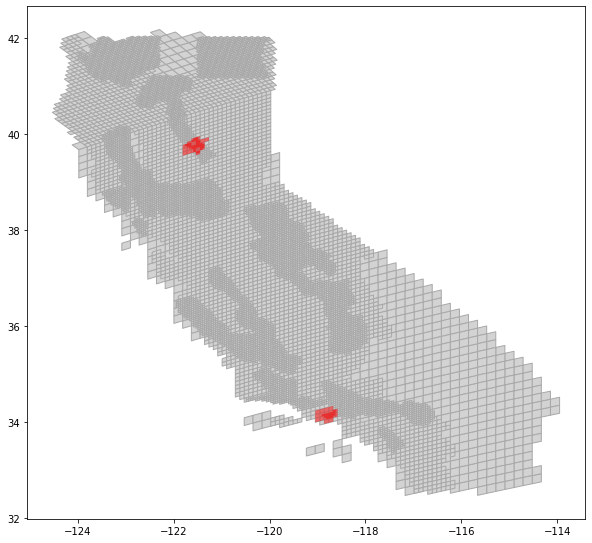

In [80]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect('equal')
ax.set_facecolor('white')
ca_df.plot(ax=ax, color='lightgrey', edgecolor='darkgrey')
ca_preds_df[ca_preds_df.WF_WildFire==1].plot(ax=ax, color='red', legend=True, alpha=0.5)
plt.show()

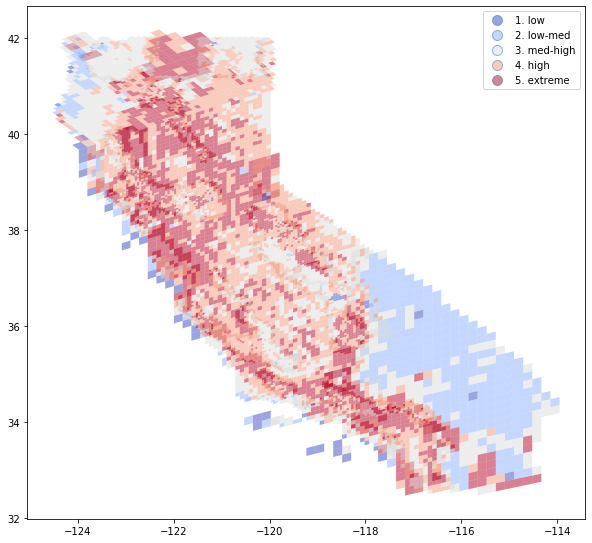

In [113]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect('equal')
ax.set_facecolor('white')
ca_preds_df.plot(ax=ax, column='noprecip_cw2000_bins', cmap='coolwarm', legend=True, alpha=0.5)
plt.show()

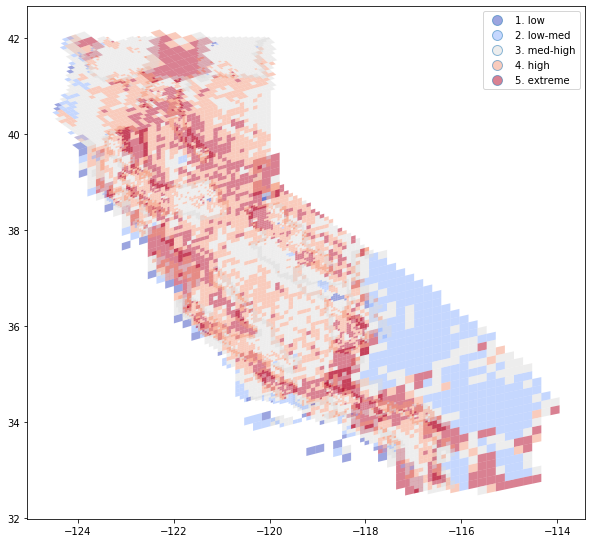

In [114]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect('equal')
ax.set_facecolor('white')
ca_preds_df.plot(ax=ax, column='precip_cw2000_bins', cmap='coolwarm', legend=True, alpha=0.5)
plt.show()

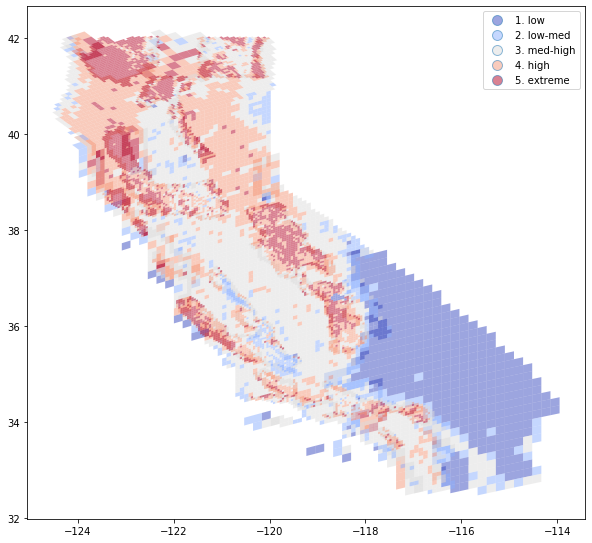

In [115]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect('equal')
ax.set_facecolor('white')
ca_preds_df.plot(ax=ax, column='noprecip_cwEQ_ext_bins', cmap='coolwarm', legend=True, alpha=0.5)
plt.show()

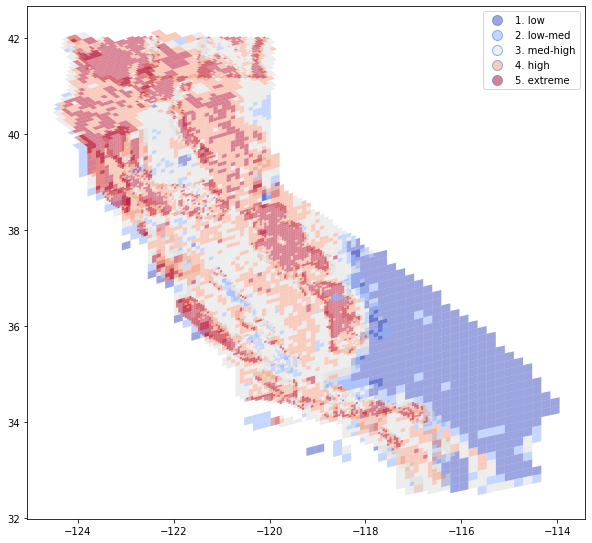

In [116]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect('equal')
ax.set_facecolor('white')
ca_preds_df.plot(ax=ax, column='precip_cwEQ_ext_bins', cmap='coolwarm', legend=True, alpha=0.5)
plt.show()

## Ranch Fire (Mendocino Complex)

In [117]:
selected_date = '2018-07-27'
ca_preds_df = ca_df.merge(ca_wf[ca_wf.WF_ALARM_DATE_DT_DT==selected_date][['S2_Cells_ID','WF_WildFire']], on='S2_Cells_ID', how='left')\
                   .merge(mlp_adam_noprecip_cw2000_probs[mlp_adam_noprecip_cw2000_probs.Date==selected_date].drop(columns='Date'), on='S2_Cells_ID')\
                   .merge(mlp_adam_precip_cw2000_probs[mlp_adam_precip_cw2000_probs.Date==selected_date].drop(columns='Date'), on='S2_Cells_ID')\
                   .merge(mlp_adam_noprecip_cwEQ_ext_probs[mlp_adam_noprecip_cwEQ_ext_probs.Date==selected_date].drop(columns='Date'), on='S2_Cells_ID')\
                   .merge(mlp_adam_precip_cwEQ_ext_probs[mlp_adam_precip_cwEQ_ext_probs.Date==selected_date].drop(columns='Date'), on='S2_Cells_ID')\
                   .fillna(0)
ca_preds_df.shape

(10643, 18)

In [90]:
ca_preds_df.WF_WildFire.sum()

154.0

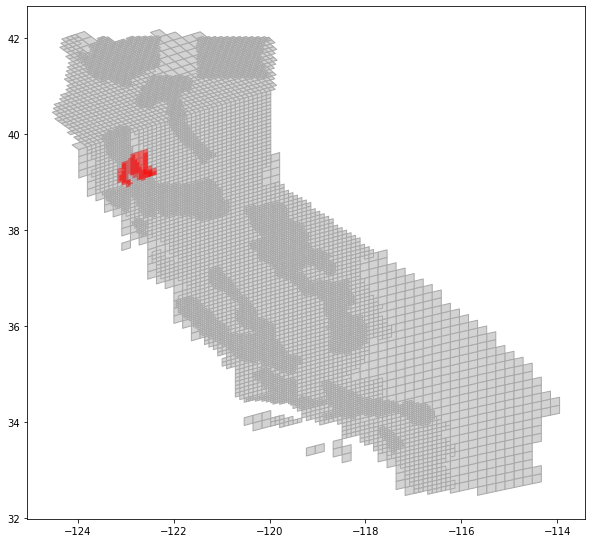

In [91]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect('equal')
ax.set_facecolor('white')
ca_df.plot(ax=ax, color='lightgrey', edgecolor='darkgrey')
ca_preds_df[ca_preds_df.WF_WildFire==1].plot(ax=ax, color='red', legend=True, alpha=0.5)
plt.show()

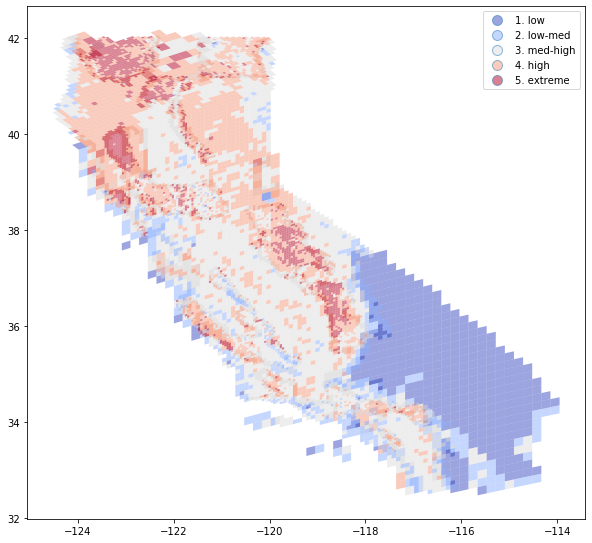

In [118]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect('equal')
ax.set_facecolor('white')
ca_preds_df.plot(ax=ax, column='noprecip_cwEQ_ext_bins', cmap='coolwarm', legend=True, alpha=0.5)
# ca_preds_df[ca_preds_df.WF_WildFire==1].plot(ax=ax, color='red', legend=True, alpha=0.5)
plt.show()

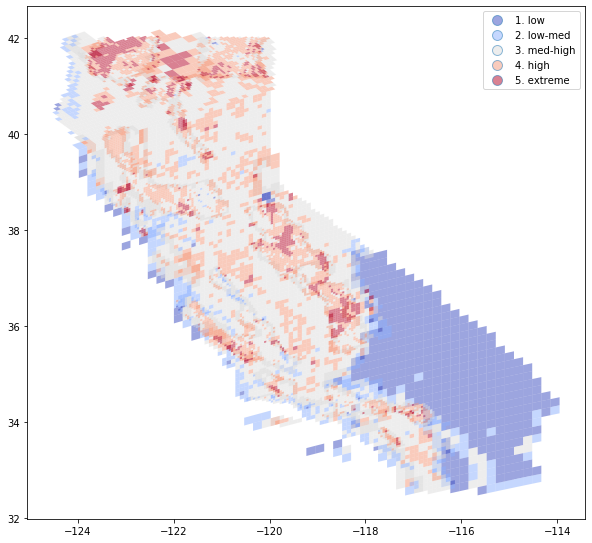

In [119]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect('equal')
ax.set_facecolor('white')
ca_preds_df.plot(ax=ax, column='precip_cwEQ_ext_bins', cmap='coolwarm', legend=True, alpha=0.5)
plt.show()